In [ ]:
import math                      
import matplotlib.pyplot as plt  
import scipy                     
import cv2                       
import numpy as np               
import glob                      
import os                        
import pandas as pd              
import tensorflow as tf       
import itertools
import random
from random import shuffle       
from tqdm import tqdm            
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [ ]:
train_dir = Path('/content/drive/My Drive/Colab Notebooks/Dataset/training/training')
test_dir  = Path('/content/drive/My Drive/Colab Notebooks/Dataset/validation/validation')

In [ ]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Dataset/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [ ]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [ ]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('/content/drive/My Drive/Colab Notebooks/Dataset/training/training/' + label)
        # print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        # print(imgfile)
        img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Dataset/training/training/'+ label +'/'+ imgfile)
        # print(img.shape)
        # print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

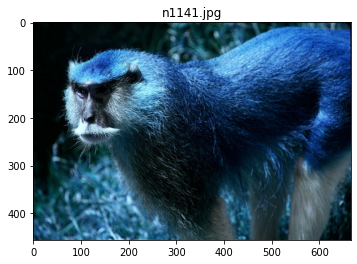

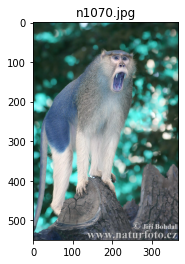

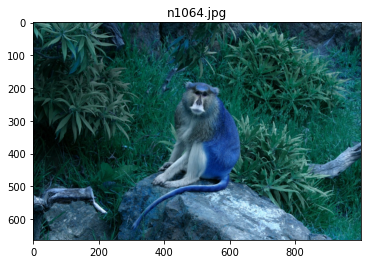

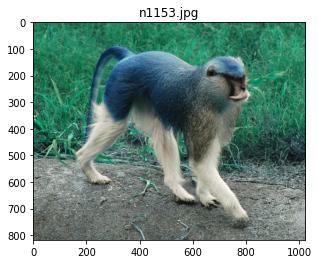

In [ ]:
image_show(4,'n1')

In [ ]:

LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.



In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)       

In [ ]:
Epochs=20
Batch_size=32
#early stopping
es=EarlyStopping(monitor="val_loss",
                           patience=5)
#fit
model_fit=model.fit(train_generator, 
                    steps_per_epoch=1098//Batch_size,
                    epochs=20, 
                    validation_data=train_generator,
                    callbacks=[es]
                   )

Epoch 1/20
34/34 [==============================] - 171s 5s/step - loss: 1.0953 - acc: 0.6093 - val_loss: 0.6950 - val_acc: 0.6466
Epoch 2/20
34/34 [==============================] - 173s 5s/step - loss: 1.0447 - acc: 0.6310 - val_loss: 0.8235 - val_acc: 0.6831
Epoch 3/20
34/34 [==============================] - 173s 5s/step - loss: 1.0228 - acc: 0.6329 - val_loss: 1.0606 - val_acc: 0.6776
Epoch 4/20
34/34 [==============================] - 168s 5s/step - loss: 0.9924 - acc: 0.6523 - val_loss: 0.6760 - val_acc: 0.6985
Epoch 5/20
34/34 [==============================] - 166s 5s/step - loss: 1.0298 - acc: 0.6370 - val_loss: 0.6598 - val_acc: 0.7040
Epoch 6/20
34/34 [==============================] - 165s 5s/step - loss: 0.8854 - acc: 0.6819 - val_loss: 0.5483 - val_acc: 0.7295
Epoch 7/20
34/34 [==============================] - 168s 5s/step - loss: 0.8482 - acc: 0.7055 - val_loss: 0.7976 - val_acc: 0.7423
Epoch 8/20
34/34 [==============================] - 167s 5s/step - loss: 0.8454 - a

In [ ]:
# Evaluate the model with test dataset

# evaluate model
test_eval = model.evaluate(validation_generator , verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


Test loss: 0.5367761850357056
Test accuracy: 0.7573529481887817


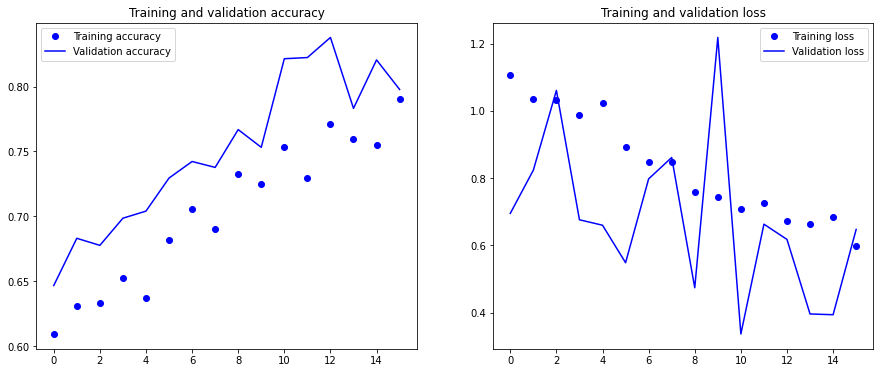

In [ ]:

accuracy = model_fit.history['acc']
val_accuracy = model_fit.history['val_acc']
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
model.save("model_save.h5")

In [ ]:
from keras.models import load_model
model_loaded = load_model('model_save.h5')

In [ ]:
model_loaded.evaluate(validation_generator )

5/5 [==============================] - 10s 2s/step


[0.5367761850357056, 0.7573529481887817]

In [ ]:
# Test the images to the model

from keras.preprocessing.image import load_img
from keras.preprocessing import image
# #load the image 
img_path="/content/drive/My Drive/Colab Notebooks/Dataset/training/training/n1/n1017.jpg"
img = load_img(path=img_path, target_size=(150, 150,3))
# #convert to array
img_arr = image.img_to_array(img)
# # prepare pixel data
img_arr=img_arr/255
# # reshape into a single sample with 3 channels
img_reshape = img_arr.reshape(1, 150, 150, 3)  

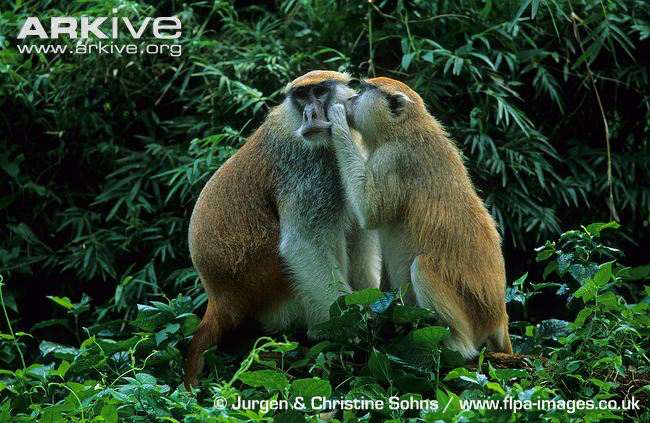

In [ ]:
Image.open(img_path)

In [ ]:
y_pred = model_loaded.predict(img_reshape)
y_pred

array([[2.2458931e-04, 7.0713723e-01, 2.1596844e-03, 2.4474332e-06,
        3.7643695e-03, 4.8631078e-04, 1.2518763e-05, 9.9162191e-02,
        1.6869231e-01, 1.8358395e-02]], dtype=float32)

In [ ]:
y_pred_label = np.argmax(y_pred, axis=1)
display(y_pred_label)

array([1])

In [ ]:
lab=train_generator.class_indices
label=list(lab.keys())
label_name=labels.tolist()

In [ ]:
print(f"label : {label[y_pred_label[0]]}")
print(f"label_name : {label_name[y_pred_label[0]]}")

label : n1
label_name :  patas_monkey                  


In [ ]:
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object